## **Optimization**

In [3]:
import numpy as np
import cvxpy as cp
import cplex
from tqdm import tqdm

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as pdr
import yfinance as yf

from dateutil.relativedelta import relativedelta
from datetime import datetime

In [4]:
market_data = pd.read_csv('./new_market.csv')

In [5]:
stocks_15 = {
    "AAPL": 0.084, "AMZN": 0.074, "NVDA": 0.064, "JPM": 0.054, "PG": 0.054,
    "PFE": 0.064, "JNJ": 0.064, "KO": 0.054, "XOM": 0.064, "NEE": 0.074,
    "GOOGL": 0.084, "MSFT": 0.084, "TSLA": 0.074, "NKE": 0.054, "BAC": 0.054
}

stocks_30 = {
    "MSFT": 0.067, "AMZN": 0.067, "NVDA": 0.067, "AAPL": 0.067, "GOOGL": 0.067,
    "ADBE": 0.067, "JNJ": 0.05, "PFE": 0.05, "MRK": 0.05, "ABT": 0.05, 
    "PG": 0.05, "KO": 0.05, "JPM": 0.05, "GS": 0.05, "CAT": 0.025, 
    "CVX": 0.025, "XOM": 0.025, "BA": 0.025, "TSLA": 0.025, "NEE": 0.025, 
    "NKE": 0.005, "VZ": 0.005, "CRM": 0.005, "UNH": 0.005, "WMT": 0.005, 
    "QCOM": 0.005, "BAC": 0.005, "V": 0.005, "MCD": 0.005, "INTC": 0.005
}

stocks_45 = {
    "AAPL": 0.05, "GOOGL": 0.04, "MSFT": 0.04, "NVDA": 0.03, "AMD": 0.03, 
    "ORCL": 0.02, "CRM": 0.02, "INTC": 0.01, "CSCO": 0.01, "JPM": 0.04, 
    "GS": 0.03, "BAC": 0.03, "MS": 0.02, "AXP": 0.02, "C": 0.01,
    "JNJ": 0.03, "UNH": 0.03, "PFE": 0.02, "ABBV": 0.02, "TSLA": 0.02, 
    "AMGN": 0.02, "GILD": 0.01, "PG": 0.03, "KO": 0.03, "NKE": 0.02, 
    "PEP": 0.02, "COST": 0.02, "WMT": 0.02, "TGT": 0.01, "XOM": 0.025, 
    "CVX": 0.025, "NEE": 0.02, "DUK": 0.01, "SO": 0.01, "SLB": 0.01,
    "MMM": 0.02, "CAT": 0.02, "HON": 0.02, "GE": 0.02, "ADP": 0.02,
    "AMZN": 0.02, "META": 0.02, "HD": 0.02, "VZ": 0.01, "MRK": 0.01
}

In [6]:
def make_dict(dict):
    dic = {}
    
    for column in dict.keys():
        dic[column] = 1/len(dict.keys())

    return dic
    
gpt15_same = make_dict(stocks_15)
gpt30_same = make_dict(stocks_30)
gpt45_same = make_dict(stocks_45)

In [7]:
market_data['pricingDate'] = pd.to_datetime(market_data['pricingDate'])
market_data.set_index('pricingDate', inplace = True)

In [8]:
# yfinance에서 데이터 가져오는 것 대신 S&P market 데이터에서 데이터 가져울 수 있게 함수 만듬
# 원하는 티커(dict에서 가져와도됨), 날짜 넣으면 됨


def download(dict, start_date, end_date):
    data = pd.DataFrame()
    a = pd.DataFrame()
    tickers = list(dict.keys())

    for ticker in tqdm(tickers):
        a = market_data.loc[start_date:end_date, ticker]
        data = pd.concat([data, a], axis=1)

    return data

## **GMV**

In [123]:
# GMV 함수

def gmv(dict):

    data = download(dict, "2018-05-01", "2023-05-01")
    ret = data.pct_change().dropna()
    
    num_assets = data.shape[1] # 종목 개수가 나와야함
    weights = cp.Variable((num_assets,1)) # 종목 개수랑 같아야함
    cov_mat = np.cov(ret.values.T) # 개별 종목 별 기대수익률을 구해서 Covariance Matrix를 만듬

    print(cov_mat)
    
    obj = cp.Minimize(cp.quad_form(weights, cov_mat)) # 목적식 설정
    
    min_weights = 0.5 * 1 / num_assets  # 각 자산별 최소 weight
    max_weights = 2 * 1 / num_assets
    
    # weights >= 0 
    const = [cp.sum(weights) == 1, 
             weights >= min_weights,
             weights <= max_weights]
    
    problem = cp.Problem(obj, const) # 문제 정의
    problem.solve(verbose=False, solver=cp.CPLEX) # 문제 풀기
    
    if problem.status == "optimal":
        w_opt = np.array(weights.value).flatten()
        print("Optimal")
        # print(gmv_weights.value[:5])
        
        # print(max(gmv_weights.value)) # 가장 큰 weight를 보고싶으면 이거 주석 해제
    else:
        print("It isn't optimal")

    return w_opt

In [124]:
gmv_15 = gmv(stocks_15)
gmv_30 = gmv(stocks_30)
gmv_45 = gmv(stocks_45)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 224.73it/s]

[[4.40689192e-04 3.11218504e-04 4.56533324e-04 1.96547168e-04
  1.22100850e-04 1.18499096e-04 1.10667527e-04 1.18650055e-04
  1.52362881e-04 1.55793816e-04 2.91857378e-04 3.13530628e-04
  4.13780693e-04 2.37679666e-04 2.18548795e-04]
 [3.11218504e-04 5.19278364e-04 4.75198604e-04 1.43360581e-04
  8.37375626e-05 8.86810990e-05 7.64648820e-05 7.45400262e-05
  1.03224379e-04 1.21426783e-04 3.12827216e-04 3.18398282e-04
  4.06182781e-04 2.24992877e-04 1.70650087e-04]
 [4.56533324e-04 4.75198604e-04 1.08469562e-03 2.57679405e-04
  1.30771998e-04 1.33005571e-04 1.09012068e-04 1.20389206e-04
  1.94923635e-04 1.96052569e-04 4.27304278e-04 4.54890942e-04
  6.66748614e-04 3.54543897e-04 2.92561413e-04]
 [1.96547168e-04 1.43360581e-04 2.57679405e-04 4.12954961e-04
  1.07574564e-04 1.26084977e-04 1.08580998e-04 1.46666718e-04
  2.60115801e-04 1.30972587e-04 1.87630258e-04 1.85184356e-04
  2.31298288e-04 2.15040066e-04 4.19441580e-04]
 [1.22100850e-04 8.37375626e-05 1.30771998e-04 1.07574564e-04
  

Optimal


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 316.71it/s]


[[3.82697858e-04 3.18398282e-04 4.54890942e-04 3.13530628e-04
  3.11032002e-04 3.68344387e-04 1.10531277e-04 1.20557957e-04
  1.11076356e-04 2.01588429e-04 1.25913874e-04 1.18215136e-04
  1.85184356e-04 2.12391178e-04 1.66917200e-04 1.71297557e-04
  1.34672865e-04 2.59626830e-04 3.68940175e-04 1.59555325e-04
  2.29007774e-04 7.62618336e-05 3.40854624e-04 1.88484627e-04
  1.15737888e-04 3.10338303e-04 2.07222668e-04 2.42286933e-04
  1.44660730e-04 2.91007755e-04]
 [3.18398282e-04 5.19278364e-04 4.75198604e-04 3.11218504e-04
  3.12827216e-04 3.62971442e-04 7.64648820e-05 8.86810990e-05
  6.70937873e-05 1.68537010e-04 8.37375626e-05 7.45400262e-05
  1.43360581e-04 1.90194381e-04 1.47027535e-04 1.13754893e-04
  1.03224379e-04 2.26766591e-04 4.06182781e-04 1.21426783e-04
  2.24992877e-04 5.51162900e-05 3.51999173e-04 1.34634408e-04
  1.03947968e-04 2.98807471e-04 1.70650087e-04 2.05989312e-04
  9.75904258e-05 2.47857266e-04]
 [4.54890942e-04 4.75198604e-04 1.08469562e-03 4.56533324e-04
  4.

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 148.74it/s]

[[4.40689192e-04 2.91857378e-04 3.13530628e-04 ... 2.20511433e-04
  7.67346752e-05 1.04055101e-04]
 [2.91857378e-04 4.01241671e-04 3.11032002e-04 ... 1.99148287e-04
  7.21695629e-05 9.07240896e-05]
 [3.13530628e-04 3.11032002e-04 3.82697858e-04 ... 2.20855722e-04
  7.62618336e-05 1.11076356e-04]
 ...
 [2.20511433e-04 1.99148287e-04 2.20855722e-04 ... 3.26587499e-04
  8.51366104e-05 9.66530370e-05]
 [7.67346752e-05 7.21695629e-05 7.62618336e-05 ... 8.51366104e-05
  1.54695066e-04 7.82746530e-05]
 [1.04055101e-04 9.07240896e-05 1.11076356e-04 ... 9.66530370e-05
  7.82746530e-05 2.11948496e-04]]


Optimal


In [24]:
# 누적 수익률 함수
# bool에 True를 넣으면 gpt gmv opt 데이터로 실행, False이면 GPT로 이미 가져와있는거 실행
def MDD(cumulative_returns):
    peak = cumulative_returns.iloc[0]
    drawdown = np.zeros(len(cumulative_returns))
    for i in range(1, len(cumulative_returns)):
        if cumulative_returns.iloc[i] > peak:
            peak = cumulative_returns.iloc[i]
        drawdown[i] = (peak - cumulative_returns.iloc[i]) / peak
    max_drawdown = np.max(drawdown)
    return max_drawdown

def STD(returns):
    std_dev = np.std(returns)
    return std_dev

def SHARPE(returns, risk_free_rate=0):
    excess_returns = returns - risk_free_rate
    mean_excess_return = np.mean(excess_returns)
    std_dev = np.std(returns)
    sharpe_ratio = mean_excess_return / std_dev if std_dev != 0 else 0
    return sharpe_ratio

def cum_ret_gmv(dic, w_opt, start_date, end_date):  
    
    result = dict(zip(list(dic.keys()), w_opt))
    data = download(dic, start_date, end_date)
    ret = data.pct_change().dropna()
    pfo_ret = ret.dot(pd.Series(result))
    cum_ret = (1 + pfo_ret).cumprod()

    print(f'포트폴리오의 MDD는: {round(MDD(cum_ret),2)*100}%')
    print(f'포트폴리오의 표준편차는: {round(STD(pfo_ret),4)}')
    
    r_f = 0.02
    print(f'포트폴리오의 Sharpe Ratio는: {round(SHARPE(pfo_ret, r_f),2)}')

    return cum_ret

def cum_ret_gpt(dic, start_date, end_date):  

    data = download(dic, start_date, end_date)
    ret = data.pct_change().dropna()
    pfo_ret = ret.dot(pd.Series(dic))
    cum_ret = (1 + pfo_ret).cumprod()

    print(f'포트폴리오의 MDD는: {round(MDD(cum_ret),2)*100}%')
    print(f'포트폴리오의 표준편차는: {round(STD(pfo_ret),4)}')
    
    r_f = 0.02
    print(f'포트폴리오의 Sharpe Ratio는: {round(SHARPE(pfo_ret, r_f),2)}')
        
    return cum_ret

In [126]:
# GMV, GPT OUT OF SAMPLE

gmv_15_out = cum_ret_gmv(stocks_15, gmv_15, '2023-05-01', '2023-10-31')
gmv_30_out = cum_ret_gmv(stocks_30, gmv_30, '2023-05-01', '2023-10-31')
gmv_45_out = cum_ret_gmv(stocks_45, gmv_45, '2023-05-01', '2023-10-31')

gpt_15_out = cum_ret_gpt(stocks_15, '2023-05-01', '2023-10-31')
gpt_30_out = cum_ret_gpt(stocks_30, '2023-05-01', '2023-10-31')
gpt_45_out = cum_ret_gpt(stocks_45, '2023-05-01', '2023-10-31')

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 515.15it/s]


포트폴리오의 MDD는: 12.0%
포트폴리오의 표준편차는: 0.0065
포트폴리오의 Sharpe Ratio는: -3.13


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 589.06it/s]


포트폴리오의 MDD는: 10.0%
포트폴리오의 표준편차는: 0.0061
포트폴리오의 Sharpe Ratio는: -3.33


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 654.42it/s]


포트폴리오의 MDD는: 8.0%
포트폴리오의 표준편차는: 0.0062
포트폴리오의 Sharpe Ratio는: -3.25


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 661.20it/s]


포트폴리오의 MDD는: 12.0%
포트폴리오의 표준편차는: 0.0082
포트폴리오의 Sharpe Ratio는: -2.4


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 669.45it/s]


포트폴리오의 MDD는: 11.0%
포트폴리오의 표준편차는: 0.008
포트폴리오의 Sharpe Ratio는: -2.44


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 656.26it/s]

포트폴리오의 MDD는: 10.0%
포트폴리오의 표준편차는: 0.0071
포트폴리오의 Sharpe Ratio는: -2.79


In [127]:
# SAME WEIGHTS IN, OUT OF SAMPLE

gpt_15_samein = cum_ret_gpt(gpt15_same, '2018-05-01', '2023-05-01')
gpt_30_samein = cum_ret_gpt(gpt30_same, '2018-05-01', '2023-05-01')
gpt_45_samein = cum_ret_gpt(gpt45_same, '2018-05-01', '2023-05-01')

gpt_15_sameout = cum_ret_gpt(gpt15_same, '2023-05-01', '2023-10-31')
gpt_30_sameout = cum_ret_gpt(gpt30_same, '2023-05-01', '2023-10-31')
gpt_45_sameout = cum_ret_gpt(gpt45_same, '2023-05-01', '2023-10-31')

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 257.09it/s]


포트폴리오의 MDD는: 34.0%
포트폴리오의 표준편차는: 0.0143
포트폴리오의 Sharpe Ratio는: -1.33


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 340.45it/s]


포트폴리오의 MDD는: 33.0%
포트폴리오의 표준편차는: 0.0138
포트폴리오의 Sharpe Ratio는: -1.39


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 333.03it/s]


포트폴리오의 MDD는: 33.0%
포트폴리오의 표준편차는: 0.0134
포트폴리오의 Sharpe Ratio는: -1.44


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 617.77it/s]


포트폴리오의 MDD는: 12.0%
포트폴리오의 표준편차는: 0.0079
포트폴리오의 Sharpe Ratio는: -2.51


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 702.09it/s]


포트폴리오의 MDD는: 10.0%
포트폴리오의 표준편차는: 0.0072
포트폴리오의 Sharpe Ratio는: -2.77


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 670.82it/s]

포트폴리오의 MDD는: 10.0%
포트폴리오의 표준편차는: 0.007
포트폴리오의 Sharpe Ratio는: -2.84


In [128]:
# GMV, GPT IN SAMPLE

gmv_15_in = cum_ret_gmv(stocks_15, gmv_15, '2018-05-01', '2023-05-01')
gmv_30_in = cum_ret_gmv(stocks_30, gmv_30, '2018-05-01', '2023-05-01')
gmv_45_in = cum_ret_gmv(stocks_45, gmv_45, '2018-05-01', '2023-05-01')
gpt_15_in = cum_ret_gpt(stocks_15, '2018-05-01', '2023-05-01')
gpt_30_in = cum_ret_gpt(stocks_30, '2018-05-01', '2023-05-01')
gpt_45_in = cum_ret_gpt(stocks_45, '2018-05-01', '2023-05-01')

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 288.31it/s]


포트폴리오의 MDD는: 31.0%
포트폴리오의 표준편차는: 0.012
포트폴리오의 Sharpe Ratio는: -1.6


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 322.33it/s]


포트폴리오의 MDD는: 28.999999999999996%
포트폴리오의 표준편차는: 0.0116
포트폴리오의 Sharpe Ratio는: -1.67


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 327.24it/s]


포트폴리오의 MDD는: 27.0%
포트폴리오의 표준편차는: 0.0114
포트폴리오의 Sharpe Ratio는: -1.69


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 312.98it/s]


포트폴리오의 MDD는: 33.0%
포트폴리오의 표준편차는: 0.0147
포트폴리오의 Sharpe Ratio는: -1.3


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 337.68it/s]


포트폴리오의 MDD는: 31.0%
포트폴리오의 표준편차는: 0.0144
포트폴리오의 Sharpe Ratio는: -1.34


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 337.12it/s]

포트폴리오의 MDD는: 33.0%
포트폴리오의 표준편차는: 0.0136
포트폴리오의 Sharpe Ratio는: -1.41


In [34]:
# S&P500 Insample 기간

snpin = yf.download('^GSPC', '2018-05-01', '2023-05-01')['Adj Close']
snp_ret_in = snpin.pct_change().dropna()
snpin = (1 + snp_ret_in).cumprod()

# S&P500 Out of Sample 기간
snpout = yf.download('^GSPC', '2023-05-01', '2023-10-31')['Adj Close']
snp_ret_out = snpout.pct_change().dropna()
snpout = (1 + snp_ret_out).cumprod()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


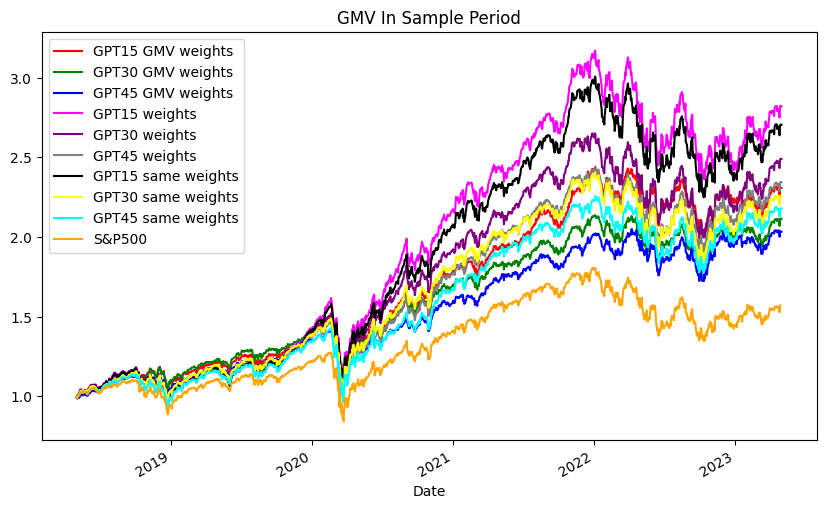

In [152]:
# GPT weights와 GPT 종목 same weights랑, Market Index랑 비교 In-sample

plt.figure(figsize=(10,6))
plt.title("GMV In Sample Period")

gmv_15_in.plot(label='GPT15 GMV weights', color='red')
gmv_30_in.plot(label='GPT30 GMV weights', color='green')
gmv_45_in.plot(label='GPT45 GMV weights', color='blue')
gpt_15_in.plot(label='GPT15 weights', color='magenta')
gpt_30_in.plot(label='GPT30 weights', color='purple')
gpt_45_in.plot(label='GPT45 weights', color='gray')
gpt_15_samein.plot(label='GPT15 same weights', color='black')
gpt_30_samein.plot(label='GPT30 same weights', color='yellow')
gpt_45_samein.plot(label='GPT45 same weights', color='cyan')

snpin.plot(label='S&P500', color='orange')

plt.legend()
plt.show()

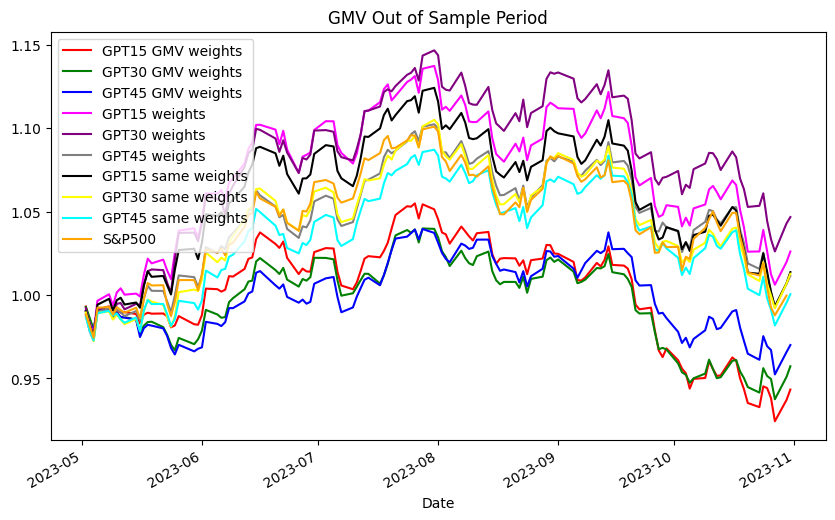

In [153]:
# GPT-GMV와 GPT종목 same weights랑, Market Index랑 비교 Out-sample

plt.figure(figsize=(10,6))
plt.title("GMV Out of Sample Period")

gmv_15_out.plot(label='GPT15 GMV weights', color='red')
gmv_30_out.plot(label='GPT30 GMV weights', color='green')
gmv_45_out.plot(label='GPT45 GMV weights', color='blue')
gpt_15_out.plot(label='GPT15 weights', color='magenta')
gpt_30_out.plot(label='GPT30 weights', color='purple')
gpt_45_out.plot(label='GPT45 weights', color='gray')
gpt_15_sameout.plot(label='GPT15 same weights', color='black')
gpt_30_sameout.plot(label='GPT30 same weights', color='yellow')
gpt_45_sameout.plot(label='GPT45 same weights', color='cyan')

snpout.plot(label='S&P500', color='orange')

plt.legend()
plt.show()

## **Max Sharpe Ratio**

In [27]:
def max_sharpe(dict):
    df = download(dict, "2018-05-01", "2023-05-01")

    mu = expected_returns.mean_historical_return(df) # pfo mean 
    S = risk_models.sample_cov(df) # cov
    ef = EfficientFrontier(mu, S)

    n_assets = len(mu)  # 자산 수
    min_weights = 0.5 * 1 / n_assets  # 각 자산별 최소 weight
    max_weights = 2 * 1 / n_assets

    for asset in mu.index:
        num = mu.index.get_loc(asset)
        ef.add_constraint(lambda w: w[num] <= max_weights)
        ef.add_constraint(lambda w: w[num] >= min_weights)
    
    ef.add_constraint(lambda w: w.sum() == 1)

    w_opt = ef.max_sharpe() # Max Sharpe ratio가 되는 weights 찾기

    w_clean = ef.clean_weights()
    print()
    ef.portfolio_performance(verbose=True) 
    # print(w_clean) # 가중치 확인
    max_weight_asset = max(w_clean, key=w_clean.get)
    max_weight_value = w_clean[max_weight_asset]

    print()
    print("가장 큰 가중치를 가진 자산:", max_weight_asset)
    print("가장 큰 가중치:", max_weight_value)

    return w_clean

In [28]:
msp_15 = max_sharpe(stocks_15)
msp_30 = max_sharpe(stocks_30)
msp_45 = max_sharpe(stocks_45)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 203.81it/s]



Expected annual return: 25.2%
Annual volatility: 25.3%
Sharpe Ratio: 0.92

가장 큰 가중치를 가진 자산: AAPL
가장 큰 가중치: 0.13333


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 235.97it/s]



Expected annual return: 19.9%
Annual volatility: 22.0%
Sharpe Ratio: 0.81

가장 큰 가중치를 가진 자산: MSFT
가장 큰 가중치: 0.06667


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 156.42it/s]



Expected annual return: 19.4%
Annual volatility: 21.2%
Sharpe Ratio: 0.82

가장 큰 가중치를 가진 자산: AAPL
가장 큰 가중치: 0.04444


In [29]:
def max_sharpe_cum_ret(dic, result, start_date, end_date):
    data = download(dic, start_date, end_date)
    ret = data.pct_change().dropna()
    pfo_ret = ret.dot(pd.Series(result)) 
    cum_ret = (1 + pfo_ret).cumprod()
    
    print(f'포트폴리오의 MDD는: {round(MDD(cum_ret),2)*100}%')
    print(f'포트폴리오의 표준편차는: {round(STD(pfo_ret),4)}')
    
    r_f = 0.02
    print(f'포트폴리오의 Sharpe Ratio는: {round(SHARPE(pfo_ret, r_f),2)}')

    return cum_ret

msf_15_out = max_sharpe_cum_ret(stocks_15, msp_15, '2023-05-01', '2023-10-31')
msf_30_out = max_sharpe_cum_ret(stocks_30, msp_30, '2023-05-01', '2023-10-31')
msf_45_out = max_sharpe_cum_ret(stocks_45, msp_45, '2023-05-01', '2023-10-31')

msf_15_in = max_sharpe_cum_ret(stocks_15, msp_15, '2018-05-01', '2023-05-01')
msf_30_in = max_sharpe_cum_ret(stocks_30, msp_30, '2018-05-01', '2023-05-01')
msf_45_in = max_sharpe_cum_ret(stocks_45, msp_45, '2018-05-01', '2023-05-01')

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 612.19it/s]


포트폴리오의 MDD는: 12.0%
포트폴리오의 표준편차는: 0.0094
포트폴리오의 Sharpe Ratio는: -2.07


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 465.79it/s]


포트폴리오의 MDD는: 10.0%
포트폴리오의 표준편차는: 0.0073
포트폴리오의 Sharpe Ratio는: -2.71


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 503.67it/s]


포트폴리오의 MDD는: 10.0%
포트폴리오의 표준편차는: 0.007
포트폴리오의 Sharpe Ratio는: -2.86


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 229.84it/s]


포트폴리오의 MDD는: 33.0%
포트폴리오의 표준편차는: 0.016
포트폴리오의 Sharpe Ratio는: -1.18


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 298.59it/s]


포트폴리오의 MDD는: 31.0%
포트폴리오의 표준편차는: 0.0138
포트폴리오의 Sharpe Ratio는: -1.38


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 306.72it/s]

포트폴리오의 MDD는: 30.0%
포트폴리오의 표준편차는: 0.0134
포트폴리오의 Sharpe Ratio는: -1.43


NameError: name 'gpt_15_in' is not defined

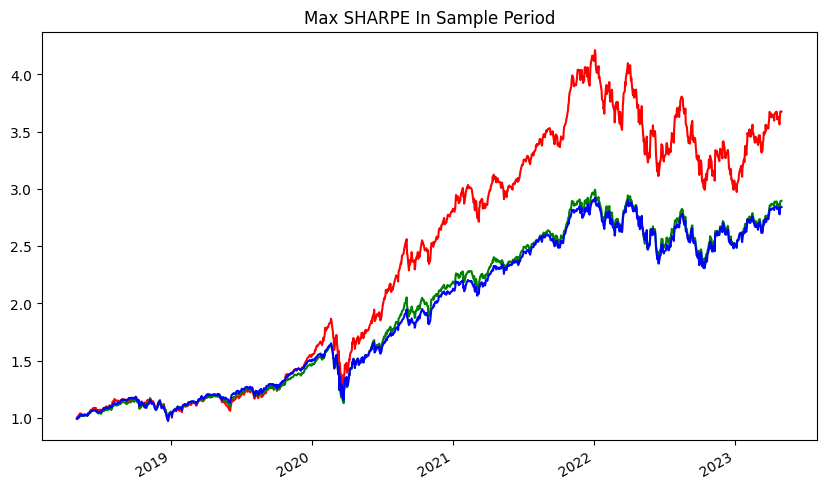

In [30]:
# SHARPE와 GPT종목 same weights랑, Market Index랑 비교 Out-sample

plt.figure(figsize=(10,6))
plt.title("Max SHARPE In Sample Period")

msf_15_in.plot(label='GPT15 Max Sharpe weights', color='red')
msf_30_in.plot(label='GPT30 Max Sharpe weights', color='green')
msf_45_in.plot(label='GPT45 Max Sharpe weights', color='blue')
gpt_15_in.plot(label='GPT15 weights', color='magenta')
gpt_30_in.plot(label='GPT30 weights', color='purple')
gpt_45_in.plot(label='GPT45 weights', color='gray')
gpt_15_samein.plot(label='GPT15 same weights', color='black')
gpt_30_samein.plot(label='GPT30 same weights', color='yellow')
gpt_45_samein.plot(label='GPT45 same weights', color='cyan')

snpin.plot(label='S&P500', color='orange')

plt.legend()
plt.show()

In [ ]:
# SHARPE와 GPT종목 same weights랑, Market Index랑 비교 Out-sample

plt.figure(figsize=(10,6))
plt.title("Max SHARPE Out of Sample Period")

msf_15_out.plot(label='GPT15 Max Sharpe weights', color='red')
msf_30_out.plot(label='GPT30 Max Sharpe weights', color='green')
msf_45_out.plot(label='GPT45 Max Sharpe weights', color='blue')
gpt_15_out.plot(label='GPT15 weights', color='magenta')
gpt_30_out.plot(label='GPT30 weights', color='purple')
gpt_45_out.plot(label='GPT45 weights', color='gray')
gpt_15_sameout.plot(label='GPT15 same weights', color='black')
gpt_30_sameout.plot(label='GPT30 same weights', color='yellow')
gpt_45_sameout.plot(label='GPT45 same weights', color='cyan')

snpout.plot(label='S&P500', color='orange')

plt.legend()
plt.show()

## **Max Expected Returns**

In [31]:
def max_return(dict):
    df = download(dict, "2018-05-01", "2023-05-01")

    mu = expected_returns.mean_historical_return(df) # pfo mean 
    S = risk_models.sample_cov(df) # cov
    ef = EfficientFrontier(mu, S, solver='ECOS')
    ef.add_constraint(lambda x: x.sum() == 1,)

    n_assets = len(mu)  # 자산 수
    min_weights = 0.5 * 1 / n_assets  # 각 자산별 최소 weight
    max_weights = 2 * 1 / n_assets
    
    for asset in mu.index:
        num = mu.index.get_loc(asset)
        ef.add_constraint(lambda w: w[num] <= max_weights)
        ef.add_constraint(lambda w: w[num] >= min_weights)

    w_opt = ef._max_return()

    w_clean = ef.clean_weights()
    print()
    ef.portfolio_performance(verbose=True) 
    # print(w_clean) # 가중치 확인
    max_weight_asset = max(w_clean, key=w_clean.get)
    max_weight_value = w_clean[max_weight_asset]

    print()
    print("가장 큰 가중치를 가진 자산:", max_weight_asset)
    print("가장 큰 가중치:", max_weight_value)

    return w_clean

In [32]:
max_ret_15 = max_return(stocks_15)
max_ret_30 = max_return(stocks_30)
max_ret_45 = max_return(stocks_45)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 227.24it/s]



Expected annual return: 26.4%
Annual volatility: 26.7%
Sharpe Ratio: 0.91

가장 큰 가중치를 가진 자산: AAPL
가장 큰 가중치: 0.13333


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 255.72it/s]



Expected annual return: 20.2%
Annual volatility: 23.4%
Sharpe Ratio: 0.78

가장 큰 가중치를 가진 자산: MSFT
가장 큰 가중치: 0.06667


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 279.99it/s]



Expected annual return: 19.6%
Annual volatility: 22.0%
Sharpe Ratio: 0.80

가장 큰 가중치를 가진 자산: AAPL
가장 큰 가중치: 0.04444


In [148]:
def max_sharpe_cum_ret(dic, result, start_date, end_date):
    data = download(dic, start_date, end_date)
    ret = data.pct_change().dropna()
    pfo_ret = ret.dot(pd.Series(result))
    cum_ret = (1 + pfo_ret).cumprod()

    print(f'포트폴리오의 MDD는: {round(MDD(cum_ret),2)*100}%')
    print(f'포트폴리오의 표준편차는: {round(STD(pfo_ret),4)}')
    
    r_f = 0.02
    print(f'포트폴리오의 Sharpe Ratio는: {round(SHARPE(pfo_ret, r_f),2)}')

    return cum_ret

max_15_out = max_sharpe_cum_ret(stocks_15, max_ret_15, '2023-05-01', '2023-10-31')
max_30_out = max_sharpe_cum_ret(stocks_30, max_ret_30, '2023-05-01', '2023-10-31')
max_45_out = max_sharpe_cum_ret(stocks_45, max_ret_45, '2023-05-01', '2023-10-31')

max_15_in = max_sharpe_cum_ret(stocks_15, max_ret_15, '2018-05-01', '2023-05-01')
max_30_in = max_sharpe_cum_ret(stocks_30, max_ret_30, '2018-05-01', '2023-05-01')
max_45_in = max_sharpe_cum_ret(stocks_45, max_ret_45, '2018-05-01', '2023-05-01')

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 600.32it/s]


포트폴리오의 MDD는: 12.0%
포트폴리오의 표준편차는: 0.0105
포트폴리오의 Sharpe Ratio는: -1.84


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 619.04it/s]


포트폴리오의 MDD는: 10.0%
포트폴리오의 표준편차는: 0.008
포트폴리오의 Sharpe Ratio는: -2.45


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 661.54it/s]


포트폴리오의 MDD는: 10.0%
포트폴리오의 표준편차는: 0.0075
포트폴리오의 Sharpe Ratio는: -2.63


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 318.72it/s]


포트폴리오의 MDD는: 33.0%
포트폴리오의 표준편차는: 0.0168
포트폴리오의 Sharpe Ratio는: -1.12


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 341.72it/s]


포트폴리오의 MDD는: 32.0%
포트폴리오의 표준편차는: 0.0147
포트폴리오의 Sharpe Ratio는: -1.29


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 325.30it/s]

포트폴리오의 MDD는: 31.0%
포트폴리오의 표준편차는: 0.0139
포트폴리오의 Sharpe Ratio는: -1.37


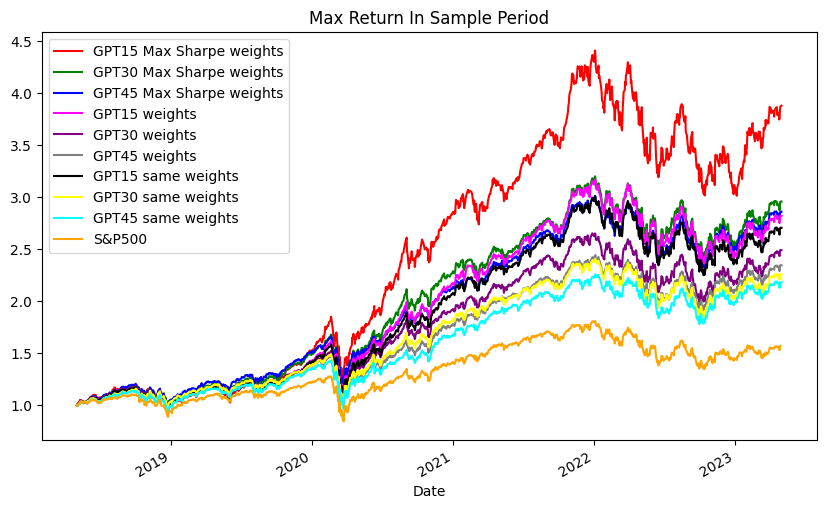

In [156]:
# SHARPE와 GPT종목 same weights랑, Market Index랑 비교 Out-sample

plt.figure(figsize=(10,6))
plt.title("Max Return In Sample Period")

max_15_in.plot(label='GPT15 Max Sharpe weights', color='red')
max_30_in.plot(label='GPT30 Max Sharpe weights', color='green')
max_45_in.plot(label='GPT45 Max Sharpe weights', color='blue')
gpt_15_in.plot(label='GPT15 weights', color='magenta')
gpt_30_in.plot(label='GPT30 weights', color='purple')
gpt_45_in.plot(label='GPT45 weights', color='gray')
gpt_15_samein.plot(label='GPT15 same weights', color='black')
gpt_30_samein.plot(label='GPT30 same weights', color='yellow')
gpt_45_samein.plot(label='GPT45 same weights', color='cyan')

snpin.plot(label='S&P500', color='orange')

plt.legend()
plt.show()

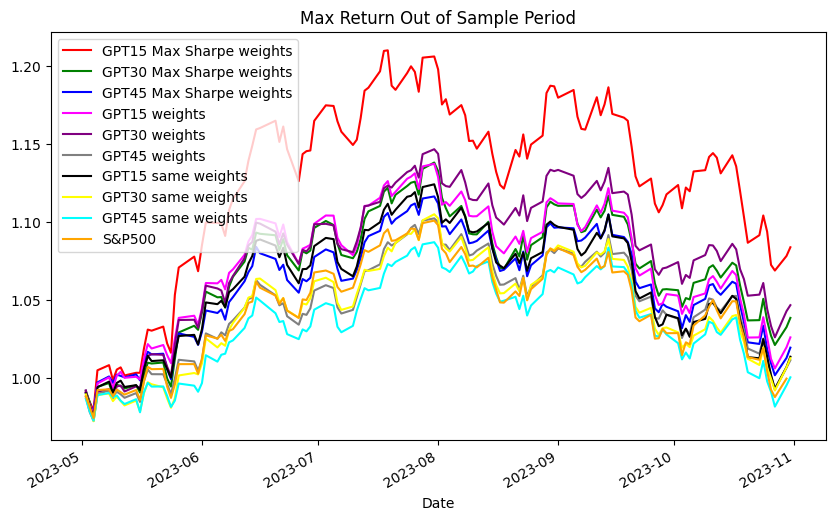

In [157]:
# SHARPE와 GPT종목 same weights랑, Market Index랑 비교 Out-sample

plt.figure(figsize=(10,6))
plt.title("Max Return Out of Sample Period")

max_15_out.plot(label='GPT15 Max Sharpe weights', color='red')
max_30_out.plot(label='GPT30 Max Sharpe weights', color='green')
max_45_out.plot(label='GPT45 Max Sharpe weights', color='blue')
gpt_15_out.plot(label='GPT15 weights', color='magenta')
gpt_30_out.plot(label='GPT30 weights', color='purple')
gpt_45_out.plot(label='GPT45 weights', color='gray')
gpt_15_sameout.plot(label='GPT15 same weights', color='black')
gpt_30_sameout.plot(label='GPT30 same weights', color='yellow')
gpt_45_sameout.plot(label='GPT45 same weights', color='cyan')

snpout.plot(label='S&P500', color='orange')

plt.legend()
plt.show()

## Other Comparison with Momentum(K-ratio)

In [15]:
# in-sample: 2018-05-01:2023-05-01
# out-of-sample: 2023-05-01:2023-10-31

import statsmodels.api as sm
import numpy as np

In [16]:
# 전체 기간 기본 모멘텀
# 티커별 수익률로 환산

ret = market_data.iloc[-1]/market_data.iloc[0]-1
ret_df = pd.DataFrame({'ticker': ret.index, 'return': ret})
ret_df = ret_df.reset_index(drop=True)

In [17]:
# 수익률 상위 20개 종목 추출

ret_rank = ret_df['return'].rank(axis=0, ascending=False)
rank_df = ret_df[ret_rank <= 20]
rank_tickers = rank_df['ticker']

In [18]:
# 전체 기간 K-ratio

data_ret = market_data.pct_change().iloc[1:]
data_cum = np.log(1 + data_ret).cumsum()
x = np.array(range(len(data_ret)))
k_ratio = {}

for i, column in enumerate(data_ret.columns):
    y = data_ret.iloc[:, i].values

    reg = sm.OLS(y, x).fit()
    result = float((reg.params/reg.bse).item())

    k_ratio[column] = result

k_ratio = pd.DataFrame.from_dict(k_ratio, orient='index').reset_index()
k_ratio.columns = ['ticker', 'K_ratio']

krat_df = ret_df.merge(k_ratio, how='left', on='ticker')
krat_df_rank = krat_df['K_ratio'].rank(axis=0, ascending=False)
krat_df_15 = krat_df[krat_df_rank <= 15]
krat_15_tickers = krat_df_15['ticker']
krat_df_30 = krat_df[krat_df_rank <= 30]
krat_30_tickers = krat_df_30['ticker']
krat_df_45 = krat_df[krat_df_rank <= 45]
krat_45_tickers = krat_df_45['ticker']

/var/folders/zc/yxghmczd4c70ghhrdh80r9cw0000gn/T/ipykernel_23206/1704776088.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  data_ret = market_data.pct_change().iloc[1:]


In [19]:
krat_df_15['ticker']

5      ACGL
18      AJG
32     ANET
43     AVGO
81     CDNS
266     LLY
283     MCK
300     MPC
327    NVDA
332    ODFL
337    ORLY
339    PANW
351     PGR
368     PWR
397    SNPS
Name: ticker, dtype: object

In [20]:
def krat_max_sharpe(dict):
    df = yf.download(dict, "2018-05-01", "2023-05-01")['Adj Close']

    mu = expected_returns.mean_historical_return(df) # pfo mean 
    S = risk_models.sample_cov(df) # cov
    ef = EfficientFrontier(mu, S)

    n_assets = len(mu)  # 자산 수
    min_weights = 0.5 * 1 / n_assets  # 각 자산별 최소 weight
    max_weights = 2 * 1 / n_assets

    for asset in mu.index:
        num = mu.index.get_loc(asset)
        ef.add_constraint(lambda w: w[num] <= max_weights)
        ef.add_constraint(lambda w: w[num] >= min_weights)
    
    ef.add_constraint(lambda w: w.sum() == 1)

    w_opt = ef.max_sharpe() # Max Sharpe ratio가 되는 weights 찾기

    w_clean = ef.clean_weights()
    print()
    ef.portfolio_performance(verbose=True) 
    # print(w_clean) # 가중치 확인
    max_weight_asset = max(w_clean, key=w_clean.get)
    max_weight_value = w_clean[max_weight_asset]

    print()
    print("가장 큰 가중치를 가진 자산:", max_weight_asset)
    print("가장 큰 가중치:", max_weight_value)

    return w_clean

In [21]:
krat_15_w = krat_max_sharpe(list(krat_df_15['ticker']))
krat_30_w = krat_max_sharpe(list(krat_df_30['ticker']))
krat_45_w = krat_max_sharpe(list(krat_df_45['ticker']))

[*********************100%%**********************]  15 of 15 completed

Expected annual return: 31.6%
Annual volatility: 22.9%
Sharpe Ratio: 1.30

가장 큰 가중치를 가진 자산: AJG
가장 큰 가중치: 0.13333
[*********************100%%**********************]  30 of 30 completed

Expected annual return: 28.6%
Annual volatility: 21.8%
Sharpe Ratio: 1.22

가장 큰 가중치를 가진 자산: AJG
가장 큰 가중치: 0.06667
[*********************100%%**********************]  45 of 45 completed

Expected annual return: 28.3%
Annual volatility: 22.2%
Sharpe Ratio: 1.18

가장 큰 가중치를 가진 자산: AAPL
가장 큰 가중치: 0.04444


In [22]:
def krat_max_sharpe_cum_ret(dict, result, start_date, end_date):
    data = yf.download(dict, start_date, end_date)['Adj Close']
    ret = data.pct_change().dropna()
    pfo_ret = ret.dot(pd.Series(result)) 
    cum_ret = (1 + pfo_ret).cumprod()
    
    print(f'포트폴리오의 MDD는: {round(MDD(cum_ret),2)*100}%')
    print(f'포트폴리오의 표준편차는: {round(STD(pfo_ret),4)}')
    
    r_f = 0.02
    print(f'포트폴리오의 Sharpe Ratio는: {round(SHARPE(pfo_ret, r_f),2)}')

    return cum_ret

In [25]:
krat_15_cum_in = krat_max_sharpe_cum_ret(list(krat_df_15['ticker']), krat_15_w, '2018-05-01', '2023-05-01')
krat_30_cum_in = krat_max_sharpe_cum_ret(list(krat_df_30['ticker']), krat_30_w, '2018-05-01', '2023-05-01')
krat_45_cum_in = krat_max_sharpe_cum_ret(list(krat_df_45['ticker']), krat_45_w, '2018-05-01', '2023-05-01')

krat_15_cum_out = krat_max_sharpe_cum_ret(list(krat_df_15['ticker']), krat_15_w, '2023-05-01', '2023-10-31')
krat_30_cum_out = krat_max_sharpe_cum_ret(list(krat_df_30['ticker']), krat_30_w, '2023-05-01', '2023-10-31')
krat_45_cum_out = krat_max_sharpe_cum_ret(list(krat_df_45['ticker']), krat_45_w, '2023-05-01', '2023-10-31')

[*********************100%%**********************]  15 of 15 completed
포트폴리오의 MDD는: 33.0%
포트폴리오의 표준편차는: 0.0144
포트폴리오의 Sharpe Ratio는: -1.3
[*********************100%%**********************]  30 of 30 completed
포트폴리오의 MDD는: 31.0%
포트폴리오의 표준편차는: 0.0137
포트폴리오의 Sharpe Ratio는: -1.37
[*********************100%%**********************]  45 of 45 completed
포트폴리오의 MDD는: 34.0%
포트폴리오의 표준편차는: 0.014
포트폴리오의 Sharpe Ratio는: -1.34
[*********************100%%**********************]  15 of 15 completed
포트폴리오의 MDD는: 7.000000000000001%
포트폴리오의 표준편차는: 0.0096
포트폴리오의 Sharpe Ratio는: -1.96
[*********************100%%**********************]  30 of 30 completed
포트폴리오의 MDD는: 6.0%
포트폴리오의 표준편차는: 0.0085
포트폴리오의 Sharpe Ratio는: -2.22
[*********************100%%**********************]  45 of 45 completed
포트폴리오의 MDD는: 6.0%
포트폴리오의 표준편차는: 0.0079
포트폴리오의 Sharpe Ratio는: -2.41


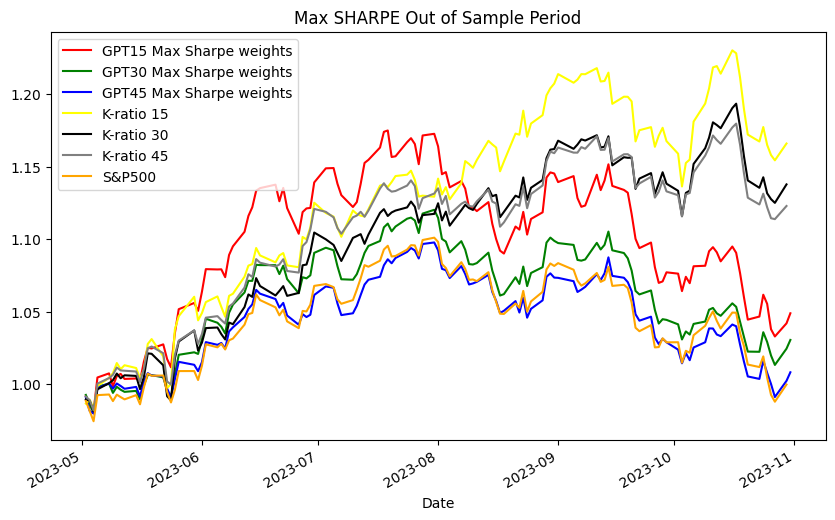

In [35]:
plt.figure(figsize=(10,6))
plt.title("Max SHARPE Out of Sample Period")

msf_15_out.plot(label='GPT15 Max Sharpe weights', color='red')
msf_30_out.plot(label='GPT30 Max Sharpe weights', color='green')
msf_45_out.plot(label='GPT45 Max Sharpe weights', color='blue')
krat_15_cum_out.plot(label='K-ratio 15', color='yellow')
krat_30_cum_out.plot(label='K-ratio 30', color='black')
krat_45_cum_out.plot(label='K-ratio 45', color='gray')

snpout.plot(label='S&P500', color='orange')

plt.legend()
plt.show()

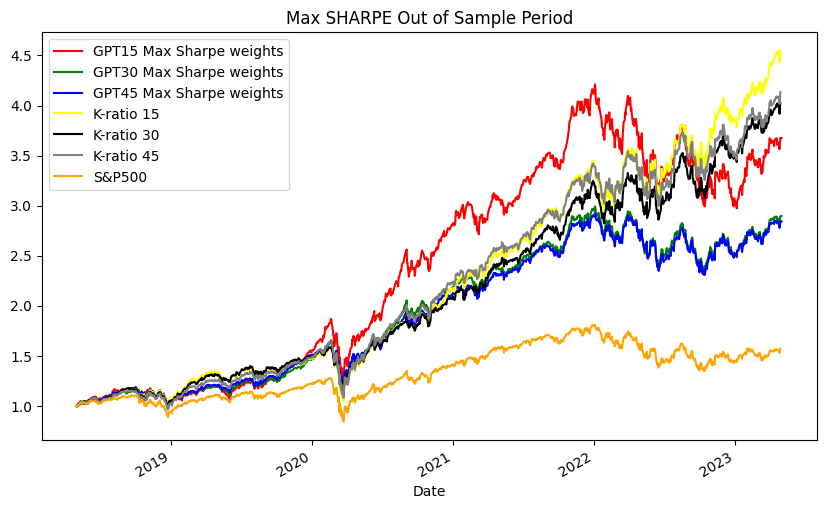

In [36]:
plt.figure(figsize=(10,6))
plt.title("Max SHARPE Out of Sample Period")

msf_15_in.plot(label='GPT15 Max Sharpe weights', color='red')
msf_30_in.plot(label='GPT30 Max Sharpe weights', color='green')
msf_45_in.plot(label='GPT45 Max Sharpe weights', color='blue')
krat_15_cum_in.plot(label='K-ratio 15', color='yellow')
krat_30_cum_in.plot(label='K-ratio 30', color='black')
krat_45_cum_in.plot(label='K-ratio 45', color='gray')

snpin.plot(label='S&P500', color='orange')

plt.legend()
plt.show()